In [1]:
from Bio import SeqIO
from Bio import pairwise2
import pandas as pd
import itertools
import numpy as np
#import plotly.graph_objects as go
import re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap


/home/pacayang/Applications/miniconda3/envs/general/lib/python3.12/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [2]:
def extract_cdr3_with_index(seq):
    # Match: start at Y(Y)C, capture in between, end at WGX (like WGQ, WGR, WGK, etc.)
    match = re.search(r'Y([A-Z])C(.+?)W[GAR][A-Z]', seq)
    if match:
        cdr3_seq = match.group(2)
        cdr3_start = match.start(1)  # start index of the matched group (CDR3)
        cdr3_end = match.end(1)      # end index (non-inclusive)
        return cdr3_seq, cdr3_start, cdr3_end
    else:
        return None, None, None
    
# Example
sequence = "\
QVQLVESGGGLVQPGGSLRL\
SCAASGFTFRLAAMGWYRQA\
PEKEREWVASITGPGTDTNY\
ADSVKGRFTVSRDNAKNTVY\
LQMNSLKPEDTAVYYCRGMG\
YWGKGTLVTVSS"

cdr3, start, end = extract_cdr3_with_index(sequence)

print("CDR3:", cdr3)
print("Start index:", start)
print("End index:", end)

def get_name(full_name):
    name = '' 
    for i in range(len(full_name.split('-'))-1):
        name += full_name.split('-')[i+1]
        name += '-'
    return name[:-1]

CDR3: RGMGY
Start index: 94
End index: 95


In [3]:
# Load sequences
seqs = list(SeqIO.parse("sequences/dog/canf1_cdr3.fasta", "fasta"))
print(seqs)
# Generate pairwise similarities
data = []
for a, b in itertools.combinations(seqs, 2):
    score = pairwise2.align.globalxx(a.seq, b.seq, one_alignment_only=True, score_only=True)
    norm_score = score / min(len(a.seq), len(b.seq))  # Normalize
    data.append([a.id, b.id, norm_score])

#df = pd.DataFrame(data, columns=["Protein1", "Protein2", "Similarity"])
#df.to_csv("similarity_matrix.csv", index=False)


[SeqRecord(seq=Seq('RGMGY'), id='2-B06', name='2-B06', description='2-B06', dbxrefs=[]), SeqRecord(seq=Seq('GARNQIYTRWDS'), id='1-D12', name='1-D12', description='1-D12', dbxrefs=[]), SeqRecord(seq=Seq('NVWANWGAPPSDFSS'), id='2-D08', name='2-D08', description='2-D08', dbxrefs=[]), SeqRecord(seq=Seq('NRRQLGVDY'), id='1-C10', name='1-C10', description='1-C10', dbxrefs=[]), SeqRecord(seq=Seq('VKLAEAGTLIHVGS'), id='1-D12-3', name='1-D12-3', description='1-D12-3', dbxrefs=[]), SeqRecord(seq=Seq('KAMNY'), id='1-C9', name='1-C9', description='1-C9', dbxrefs=[]), SeqRecord(seq=Seq('YYCNAWLGAGSDY'), id='1-B6-B05', name='1-B6-B05', description='1-B6-B05', dbxrefs=[])]


In [4]:
def get_similarity(df):
    similarity_matrix = np.zeros((len(df), len(df)))
    similarity_matrix_cdr3 = np.zeros((len(df), len(df)))
    df['ID'] = df['Name'].apply(lambda x: get_name(x))
    #df['CDR3'] = df['Sequence'].apply(lambda x: extract_cdr3_with_index(x)[0])
    for i in range(len(df)):
        for j in range(i, len(df)):
            seq1 = df['Sequence'][i]
            seq2 = df['Sequence'][j]
            score = pairwise2.align.globalxx(seq1, seq2, one_alignment_only=True, score_only=True)
            norm_score = score / min(len(seq1), len(seq2))  # Normalize
            similarity_matrix[i][j] = norm_score

            seq1_cdr = df['CDR3'][i]
            seq2_cdr = df['CDR3'][j]
            score = pairwise2.align.globalxx(seq1_cdr, seq2_cdr, one_alignment_only=True, score_only=True)
            norm_score2 = score / min(len(seq1_cdr), len(seq2_cdr))  # Normalize
            similarity_matrix_cdr3[i][j] = norm_score2
    return similarity_matrix, similarity_matrix_cdr3

def draw_similarity(matrix, linewidths=7):
    orig_cmap = sns.color_palette("rocket_r", as_cmap=True)
    new_cmap = LinearSegmentedColormap.from_list("white_to_rocket", ["white"] + [orig_cmap(i) for i in np.linspace(0.05, 1, 256)],)
    sns.heatmap(matrix, cmap=new_cmap, linewidths=linewidths, linecolor='white', vmin=0, vmax=1, cbar=False, square=True)
    plt.title("Separated Pixels with Seaborn")
    plt.show()

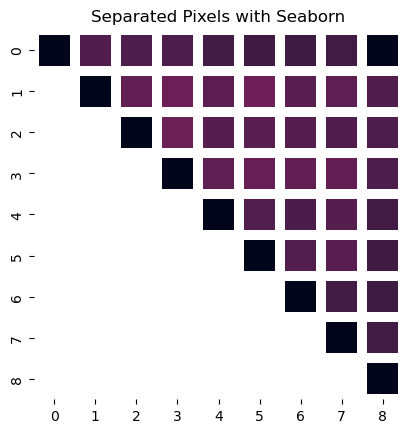

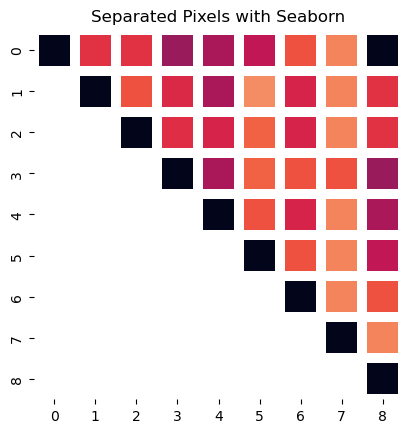

In [5]:
cat_df = pd.read_csv('sequences/feld.csv')
similarity_matrix, similarity_matrix_cdr3 = get_similarity(cat_df)
draw_similarity(similarity_matrix)
draw_similarity(similarity_matrix_cdr3)

In [6]:
similarity_matrix_cdr3

array([[1.        , 0.4       , 0.4       , 0.6       , 0.55555556,
        0.5       , 0.33333333, 0.22222222, 1.        ],
       [0.        , 1.        , 0.33333333, 0.42857143, 0.55555556,
        0.2       , 0.44444444, 0.22222222, 0.4       ],
       [0.        , 0.        , 1.        , 0.41666667, 0.44444444,
        0.3       , 0.44444444, 0.22222222, 0.4       ],
       [0.        , 0.        , 0.        , 1.        , 0.55555556,
        0.3       , 0.33333333, 0.33333333, 0.6       ],
       [0.        , 0.        , 0.        , 0.        , 1.        ,
        0.33333333, 0.44444444, 0.22222222, 0.55555556],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        1.        , 0.33333333, 0.22222222, 0.5       ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 1.        , 0.22222222, 0.33333333],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 1.        , 0.22222222],


/tmp/ipykernel_2756383/2747628718.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ID'] = df['Name'].apply(lambda x: get_name(x))


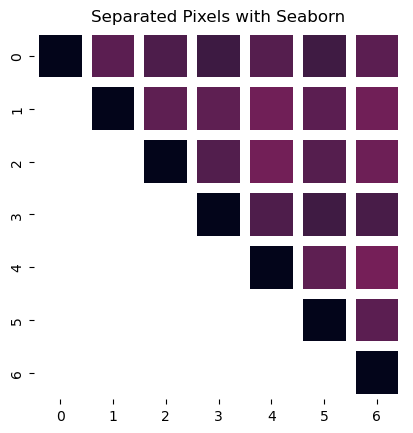

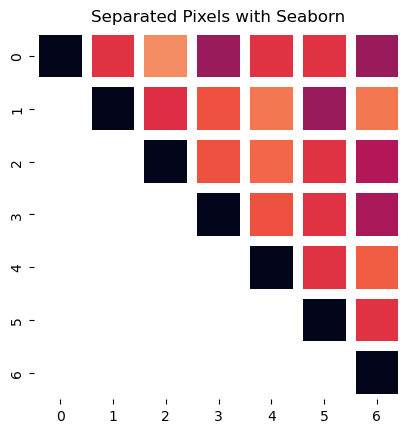

   index Target Sequences              Name  \
0      7          Can f 2  >SDAB22118-1-F04   
1      8          Can f 2  >SDAB22118-1-B11   
2      9          Can f 2  >SDAB22118-1-D05   
3     10          Can f 2  >SDAB22118-1-D08   
4     11          Can f 2  >SDAB22118-2-G01   

                                            Sequence     EC50   Tagg  \
0  QVQLVESGGGLVQPGGSLRLSCAYSGFTLDNNVIGWFRQAPGKERE...  0.06388  48.08   
1  AVQLVESGGGLVQPGGSLRLSCAASGFTFSNYYMSWYRQAPGKERE...  0.16440  44.54   
2  QVQLVESGGGLVQAGGSLGLSCAASGRTFNNYVMGWFRQAPGKERE...  0.07620  39.54   
3  EVQLVESGGGLVQPGGSLRLSCVVSGSIFSDNAMGWYRQAPGKQRE...  0.04863  40.82   
4  AVQLVDSGGGLVQAGDSLRLSCVASGRTFSSYVMGWFRQAPGKERL...  0.07356  38.93   

                                 Tm             CDR3  
0                             58.63  AAGAILLPTERRYDY  
1                             55.17        KTRLWGNDY  
2  Tm1: 48.35 Tm2: 58.58 Tm3: 64.58  AAGAILMPTERTYDY  
3  Tm1: 38.89 Tm2: 43.62 Tm3: 54.69         KDFSAPRY  
4        

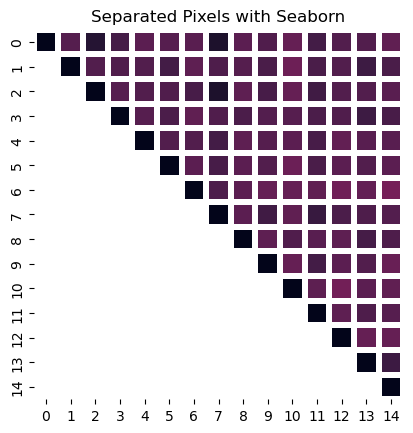

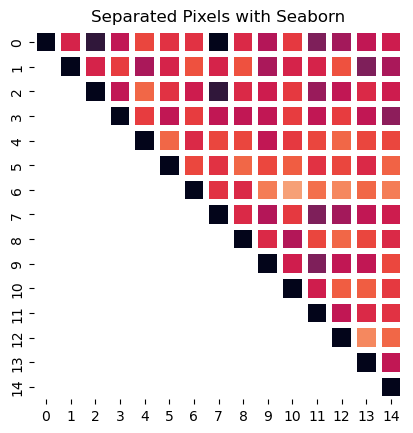

In [7]:
dog_df = pd.read_csv('sequences/canf.csv')
canf1 = dog_df[dog_df['Target Sequences'] == 'Can f 1']
similarity_matrix, similarity_matrix_cdr3 = get_similarity(canf1)
draw_similarity(similarity_matrix)
draw_similarity(similarity_matrix_cdr3)

canf2 = dog_df[dog_df['Target Sequences'] == 'Can f 2'].reset_index()
print(canf2.head())
similarity_matrix, similarity_matrix_cdr3 = get_similarity(canf2)
draw_similarity(similarity_matrix, linewidths=4)
draw_similarity(similarity_matrix_cdr3, linewidths=4)

/tmp/ipykernel_2756383/2747628718.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ID'] = df['Name'].apply(lambda x: get_name(x))


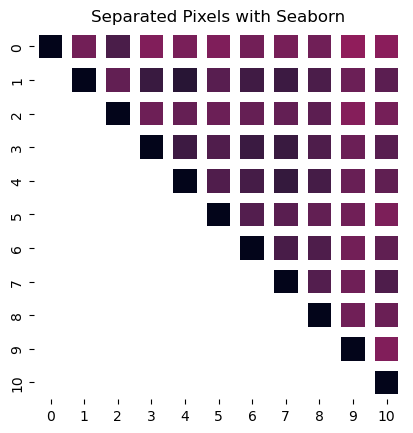

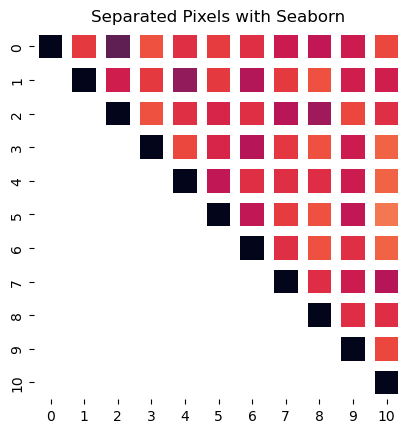

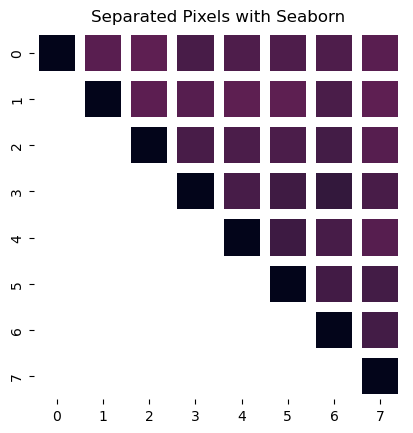

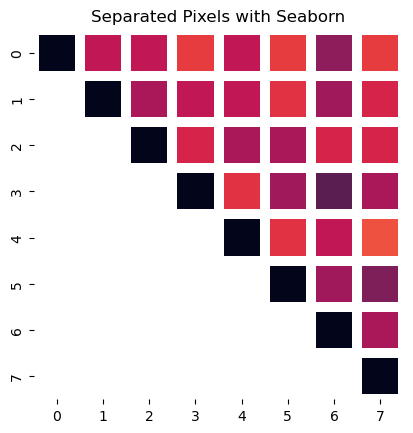

In [8]:
dust_df = pd.read_csv('sequences/derp.csv')
derp1 = dust_df[dust_df['Target Sequences'] == 'Der p 1']
similarity_matrix, similarity_matrix_cdr3 = get_similarity(derp1)
draw_similarity(similarity_matrix)
draw_similarity(similarity_matrix_cdr3)

derp2 = dust_df[dust_df['Target Sequences'] == 'Der p 2'].reset_index()
similarity_matrix, similarity_matrix_cdr3 = get_similarity(derp2)
draw_similarity(similarity_matrix)
draw_similarity(similarity_matrix_cdr3)

In [9]:
canf1

,Target Sequences,Name,Sequence,EC50,Tagg,Tm,CDR3,ID
0,Can f 1,>SDAB22112-2-B06,QVQLVESGGGLVQPGGSLRLSCAASGFTFRLAAMGWYRQAPEKERE...,0.1442,48,Tm1: 56.38 Tm2: 63.74 Tm3: 70.13,RGMGY,2-B06
1,Can f 1,>SDAB22112-1-D12,AVQLVDSGGGLVQAGGSLRLACAASGRTFDTYAVGWFRQAPGKERD...,4.0080,49.15,57.78,GARNQIYTRWDS,1-D12
2,Can f 1,>SDAB22112-2-D08,QVKLEESGGGLVQAGGSLRLSCVASGRTFSRWHTGWYRQAPGRERE...,5.8450,TBD,TBD,NVWANWGAPPSDFSS,2-D08
3,Can f 1,>SDAB22112-1-C10,QLQLVESGGGLVQPGGSLRLSCAASGFTFSSYSMSWYRQAPGKERE...,9.4010,TBD,TBD,NRRQLGVDY,1-C10
4,Can f 1,>SDAB22112-1-D12-3,QVQLVESGGGLVQPGGSLRLSCAASGFTFSNYGMSWVRQAPGKGLE...,10.3900,TBD,TBD,VKLAEAGTLIHVGS,1-D12-3
5,Can f 1,>SDAB22112-1-C9,QLQLVESGGGLVQPGGSLRLSCVGSGFTFSLASMGWYRQAPGKERE...,13.1400,TBD,TBD,KAMNY,1-C9
6,Can f 1,>SDAB22112-1-B6-B05,QLQLVESGGGLVQPGGSLRLSCAASRSIFSSYVMAWYRRAPGKKRE...,8.4180,TBD,TBD,YYCNAWLGAGSDY,1-B6-B05


In [3]:
# Similar for all nanobodies

df_all = pd.read_csv('sequences/derp.csv', index_col=False)
df_all = pd.concat([df_all, pd.read_csv('sequences/feld.csv')])
df_all = pd.concat([df_all, pd.read_csv('sequences/canf.csv')])
df_all.drop_duplicates(subset='Sequence', inplace=True)
df_all.reset_index(inplace=True)
df_all

,index,Target Sequences,Name,Sequence,EC50,Tagg,Tm,Note,CDR3
0,0,Der p 1,>SDAB22129-55-35-46-49-1-B02,QLQLVESGGGLVQSGGSLRLSCVAKGGTNHPYPIGWFRQAPGKEQE...,0.019260,TBD,TBD,NaN,AAPREIYIDSRCATYKYEY
1,1,Der p 1,>SDAB22129-55-35-46-49-1-C12[EZ1],QVQLVESGGGLVQAGGSLRLSCAASGRTFSSYAMGWFRQAPGKERE...,4.948000,TBD,TBD,NaN,AADFLGPKSWPSY
2,2,Der p 1,>SDAB22129-55-35-46-49-1-D04,QLQLVESGGGLVQPGGSLRLSCVISGGTFHPYPIGWFREAPGKERE...,0.062090,TBD,TBD,NaN,AAPREIYVDPYCPTYAYEY
3,3,Der p 1,>SDAB22129-55-35-46-49-1-D01,QVQLVESGGGLVQAGGSLRLSCAASGRTFSRYAMGWFRQAPGKERE...,0.014680,TBD,TBD,NaN,VQGWAEATMTSLGEDYDY
4,4,Der p 1,>SDAB22129-55-35-46-49-1-G07,QVQLVESGGGLVQAGGSLRLSCAASGRTFSSYAMGWFRQAPGKERE...,0.484600,TBD,TBD,Strong inhibition of Der p 1 activity,AADFASTVGTPLTRPAY
5,5,Der p 1,>SDAB22129-55-35-46-49-1-G09,QVKLEESGGGAVQPGGSLRLSCTASGQTFSNYIISWFRQAPGKERE...,0.154300,TBD,TBD,NaN,AADGLVLTAAAAEYDY
6,6,Der p 1,>SDAB22129-55-35-46-49-1-A03,QVQLVESGGGLVQAGGSLRLSCAVSGRTVSRNVMGWFRQAPGKERE...,0.029110,TBD,TBD,NaN,AAPSLPLLTSDLHDYDY
7,7,Der p 1,>SDAB22129-55-35-46-49-1-B12,QVQLVESGGGLVQAGGPLRLSCAASGRTFSSYAMGWFRQAPGKERE...,1.767000,TBD,TBD,NaN,AVPSSGRGTYYYTLSAYEY
8,8,Der p 1,>SDAB22129-55-35-46-49-1-G02,QLQLVESGGGLVQAGGSLRLSCTASGRTFRNFGMGWFRQAPGKERK...,4.207000,TBD,TBD,NaN,AARNPNRNEYPW
9,9,Der p 1,>SDAB22129-55-35-46-49-1-A04,QLQLVESGGGLVQPGGSLRLSCAASGRVYNSWTMAWFRQAPGKERE...,3.408000,TBD,TBD,NaN,AAKSGTIRATSEGQYNY


In [4]:
length_ = [len(seq) for seq in df_all['Sequence']]
np.average(length_)

np.float64(120.38775510204081)

In [ ]:
similarity_matrix, similarity_matrix_cdr3 = get_similarity(df_all)

draw_similarity(similarity_matrix, linewidths=0)
draw_similarity(similarity_matrix_cdr3, linewidths=0)

In [ ]:
lst1 = []
lst2 = []
similarity = []
for i in range(len(similarity_matrix_cdr3)):
    for j in range(len(similarity_matrix_cdr3)):
        lst1.append(i)
        lst2.append(j)
        similarity.append(similarity_matrix_cdr3[i][j])

df = pd.DataFrame(data={'seq1': lst1, 'seq2':lst2, 'similarity': similarity})
df.to_csv('similarity_matrix.csv', index=False)
df_all['Name'].to_csv('seq_names.csv')